Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also u

Epoch [1/50], Loss: 0.0467, Accuracy: 51.20%
Validation Accuracy: 96.00%


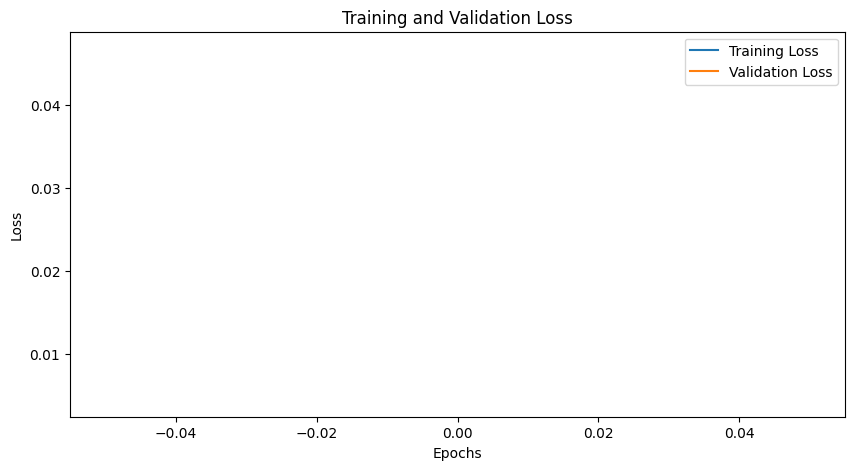

Epoch [2/50], Loss: 0.0101, Accuracy: 94.40%
Validation Accuracy: 98.00%


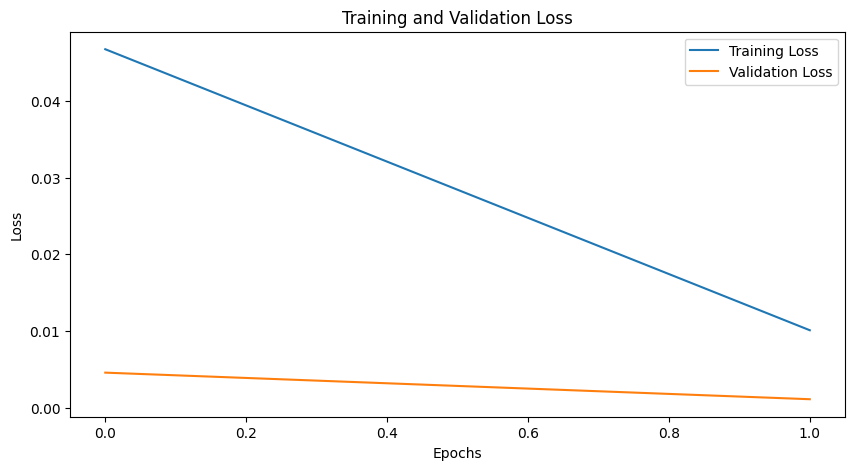

Epoch [3/50], Loss: 0.0047, Accuracy: 96.40%
Validation Accuracy: 96.00%


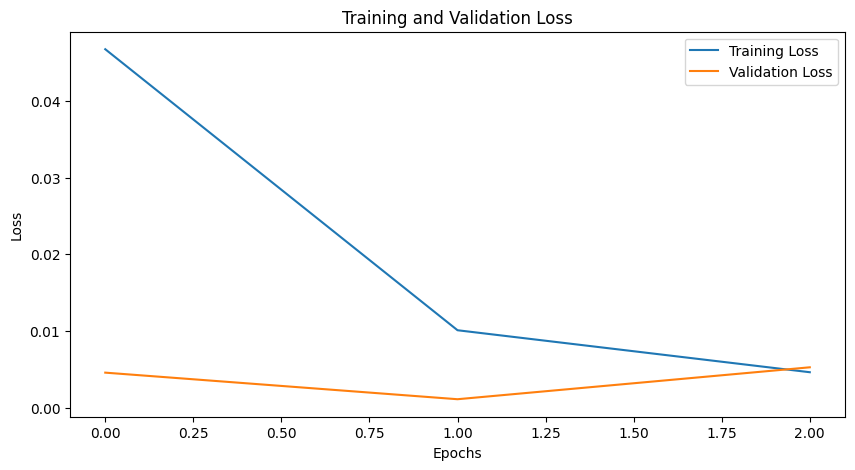

Epoch [4/50], Loss: 0.0173, Accuracy: 95.20%
Validation Accuracy: 90.00%


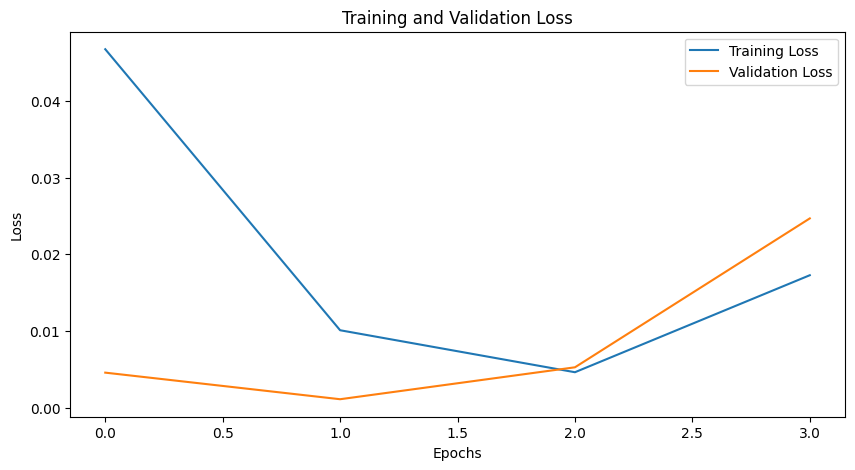

Epoch [5/50], Loss: 0.0269, Accuracy: 93.60%
Validation Accuracy: 98.00%


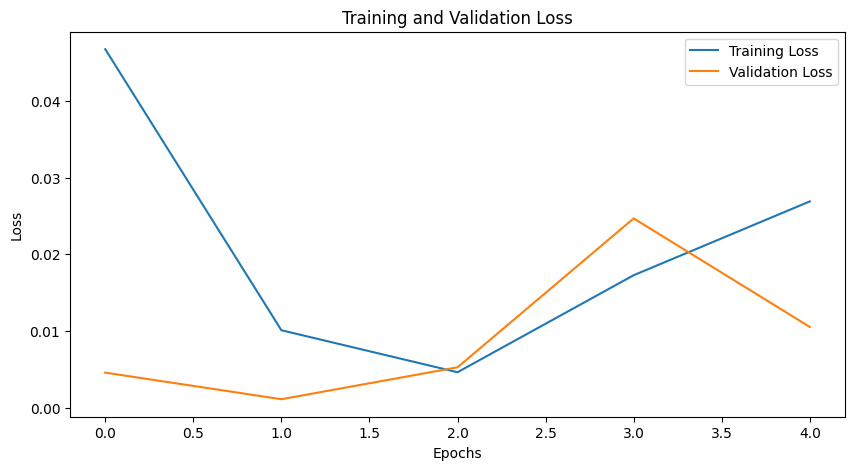

Epoch [6/50], Loss: 0.0306, Accuracy: 95.60%
Validation Accuracy: 94.00%


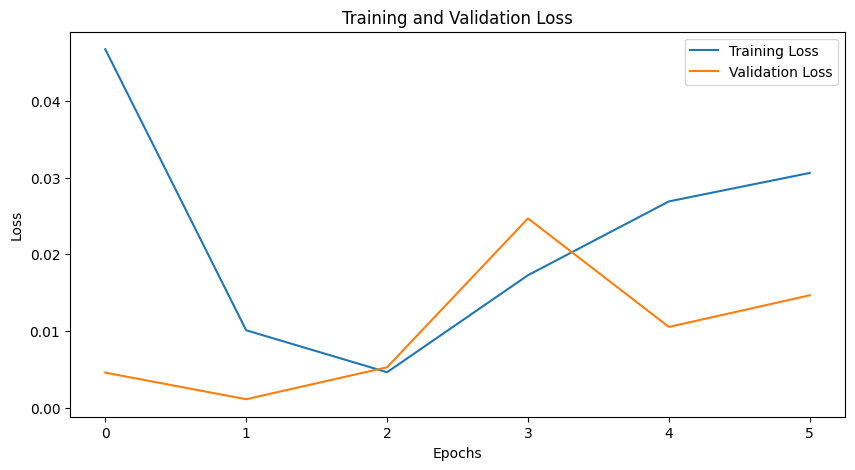

Epoch [7/50], Loss: 0.0306, Accuracy: 96.80%
Validation Accuracy: 100.00%


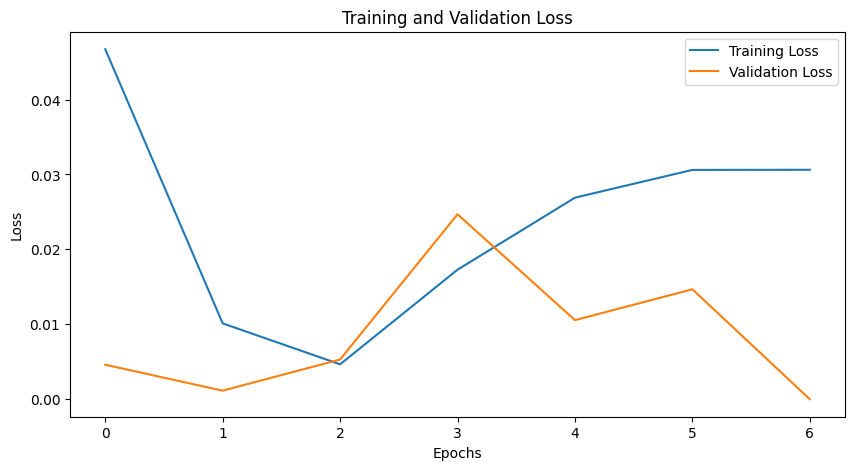

Epoch [8/50], Loss: 0.0033, Accuracy: 98.80%
Validation Accuracy: 100.00%


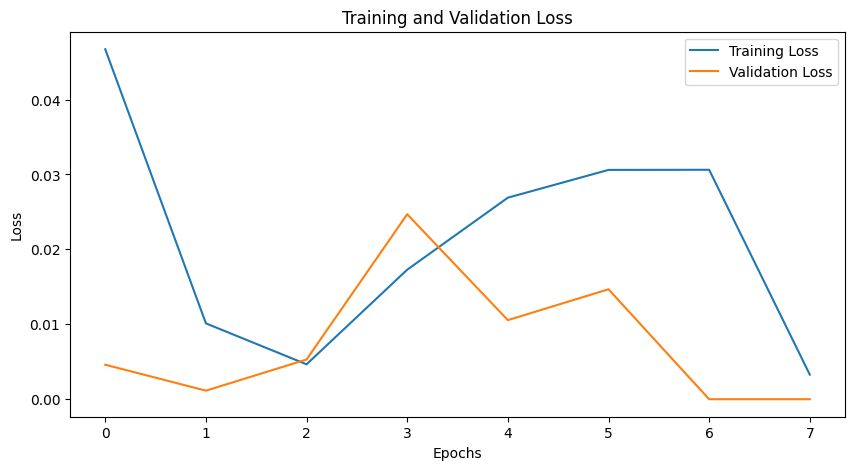

Epoch [9/50], Loss: 0.0028, Accuracy: 98.80%
Validation Accuracy: 100.00%


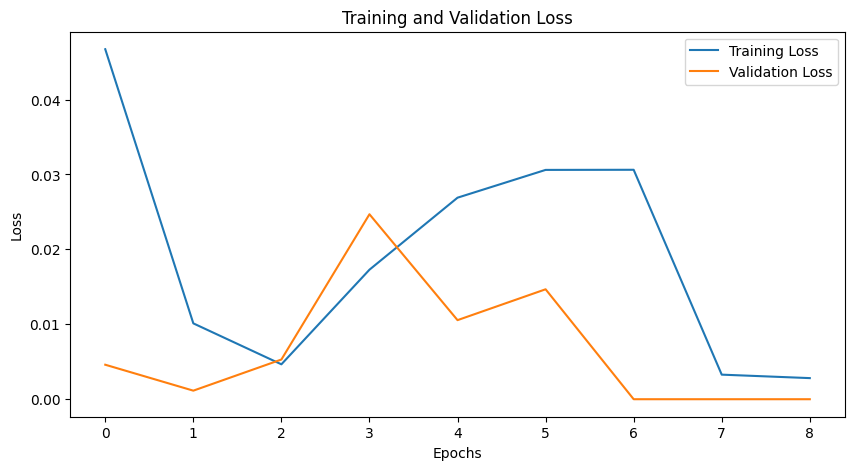

Epoch [10/50], Loss: 0.0012, Accuracy: 99.60%
Validation Accuracy: 100.00%


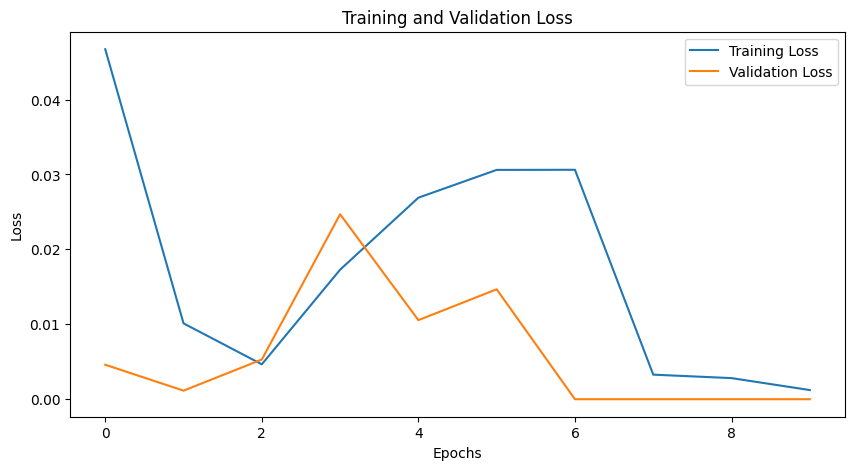

Epoch [11/50], Loss: 0.0004, Accuracy: 99.60%
Validation Accuracy: 100.00%


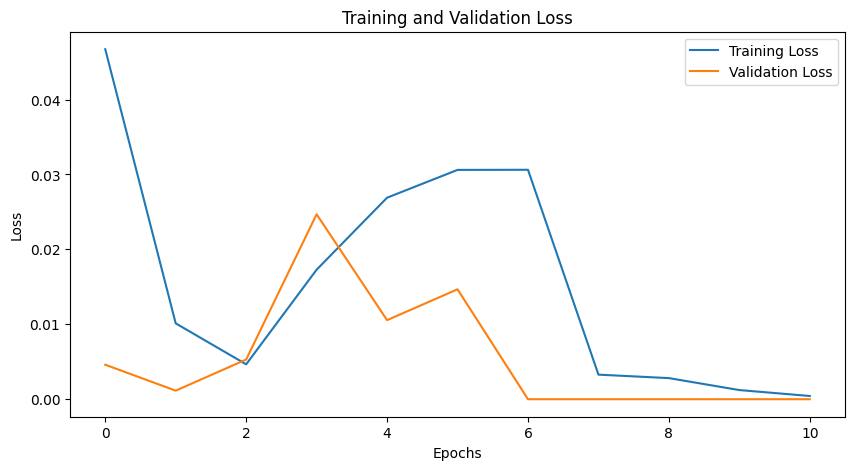

Epoch [12/50], Loss: 0.0032, Accuracy: 99.20%
Validation Accuracy: 100.00%
Early stopping at epoch 12. Best Validation Accuracy: 100.00%
Training Accuracy: 100.00%
Validation Accuracy: 100.00%
Testing Accuracy: 99.00%


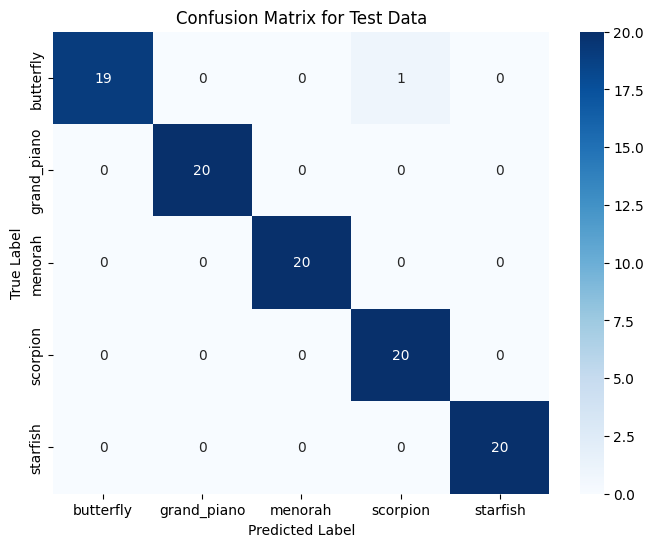

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True Label: butterfly, Predicted Label: butterfly
True Label: butterfly, Predicted Label: butterfly
True Label: butterfly, Predicted Label: butterfly
True Label: butterfly, Predicted Label: scorpion
True Label: butterfly, Predicted Label: butterfly
True Label: butterfly, Predicted Label: butterfly
True Label: butterfly, Predicted Label: butterfly
True Label: butterfly, Predicted Label: butterfly
True Label: butterfly, Predicted Label: butterfly
True Label: butterfly, Predicted Label: butterfly
True Label: butterfly, Predicted Label: butterfly
True Label: butterfly, Predicted Label: butterfly
True Label: butterfly, Predicted Label: butterfly
True Label: butterfly, Predicted Label: butterfly
True Label: butterfly, Predicted Label: butterfly
True Label: butterfly, Predicted Label: butterfly
True Label: butterfly, Predicted Label: butterfly
True Label: butterfly, Predicted Label: butterfly
True Label: butterfly, Predicted Label: butterfly
True Label: butterfly, Predicted Label: butterfly
T

In [1]:
import torch
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import zipfile
import os
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import StepLR

# Paths and data extraction
zip_path = "/content/Data.zip"
extract_path = "/content/extracted_data"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Define paths to the train, validation, and test directories within the extracted folder
base_dir = os.path.join(extract_path, "Data")
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Check for GPU and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations: Resize to 224x224, data augmentation, and normalize using ImageNet stats
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Augmentation: horizontal flip
    transforms.RandomRotation(10),      # Augmentation: random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Augmentation: color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform_val_test)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_val_test)

# Data loaders with optimized settings
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Load VGG19 model pretrained on ImageNet
vgg19 = models.vgg19(pretrained=True)

# Modify the fully connected layer for 5-class classification and add dropout layers to prevent overfitting
vgg19.classifier[2] = nn.Dropout(p=0.5)  # Dropout to prevent overfitting
vgg19.classifier[5] = nn.Dropout(p=0.5)  # Dropout to prevent overfitting
vgg19.classifier[6] = nn.Linear(4096, 5)

# Freeze the convolutional layers, but unfreeze batch norm layers
for name, param in vgg19.named_parameters():
    if "features" in name and "bn" not in name:  # Allow batch norm to be trainable
        param.requires_grad = False

vgg19.to(device)

# Define loss function and optimizer with weight decay for regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg19.classifier.parameters(), lr=0.001, weight_decay=1e-5)  # Add weight decay
scaler = GradScaler()

# Add a learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# Implement Early Stopping
best_val_accuracy = 0
patience = 5
patience_counter = 0

# Lists to track training and validation losses
training_losses = []
validation_losses = []

# Train the model with early stopping, data augmentation, dropout, and scheduler
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    global best_val_accuracy, patience_counter
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast(device_type=str(device)):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        training_losses.append(running_loss / total)

        # Validation step
        val_accuracy, val_loss = validate_model(model, val_loader)
        validation_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/total:.4f}, Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Accuracy: {val_accuracy:.2f}%")

        # Early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Validation Accuracy: {best_val_accuracy:.2f}%")
            break

        # Step the learning rate scheduler
        scheduler.step()

        # Plot losses after each epoch
        plot_losses()

# Validate the model and calculate accuracy/loss
def validate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type=str(device)):
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    val_loss = running_loss / total
    return 100 * correct / total, val_loss

# Test the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type=str(device)):
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Plot training and validation losses
def plot_losses():
    plt.figure(figsize=(10,5))
    plt.plot(training_losses, label="Training Loss")
    plt.plot(validation_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

# Confusion Matrix Plot
def plot_confusion_matrix(loader, model, dataset_name):
    model.eval()
    y_pred = []
    y_true = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type=str(device)):
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                y_pred.extend(predicted.cpu().numpy())
                y_true.extend(labels.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.title(f"Confusion Matrix for {dataset_name} Data")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

def unnormalize(img):
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    return img


def print_test_outputs(model, test_loader):
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type=str(device)):
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                # Print predictions and true labels
                for i in range(len(labels)):
                    print(f"True Label: {test_dataset.classes[labels[i]]}, Predicted Label: {test_dataset.classes[predicted[i]]}")
            break  # Only print for one batch

# Train the model
train_model(vgg19, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50)

# Calculate accuracies
train_accuracy = validate_model(vgg19, train_loader)[0]
val_accuracy = validate_model(vgg19, val_loader)[0]
test_accuracy = test_model(vgg19, test_loader)

print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Validation Accuracy: {val_accuracy:.2f}%")
print(f"Testing Accuracy: {test_accuracy:.2f}%")

# Plot confusion matrix for test data
plot_confusion_matrix(test_loader, vgg19, "Test")

# Visualization of activations
image, _ = train_dataset[0]
print_test_outputs(vgg19, test_loader)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-2-c3f740141f4d>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in 

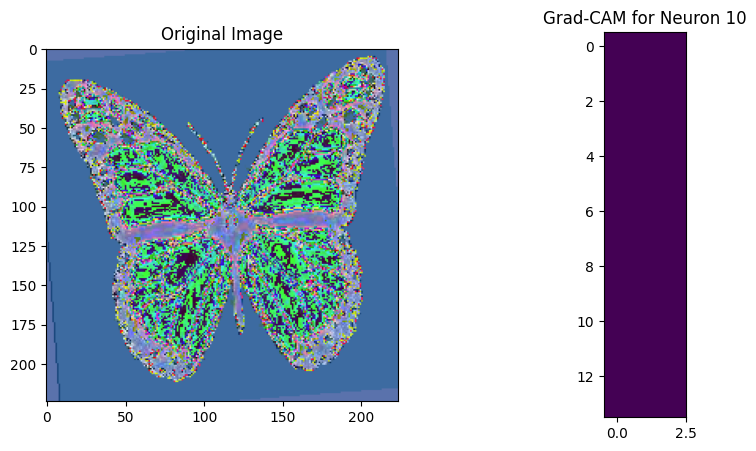

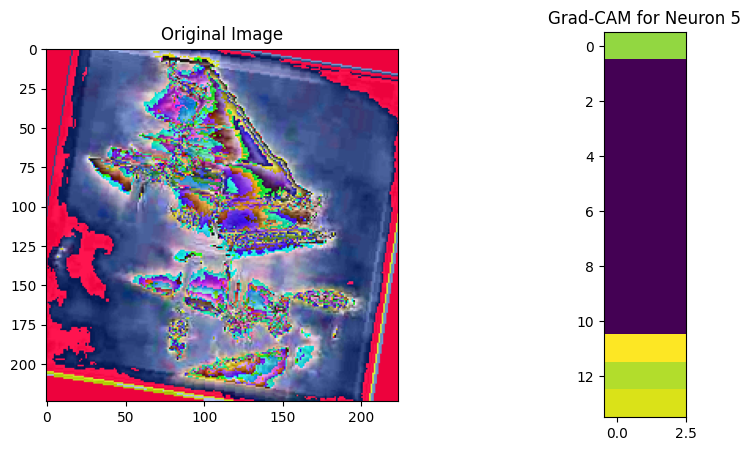

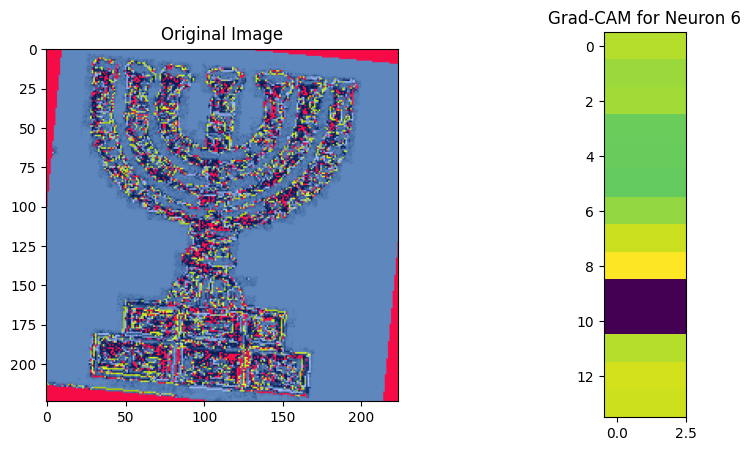

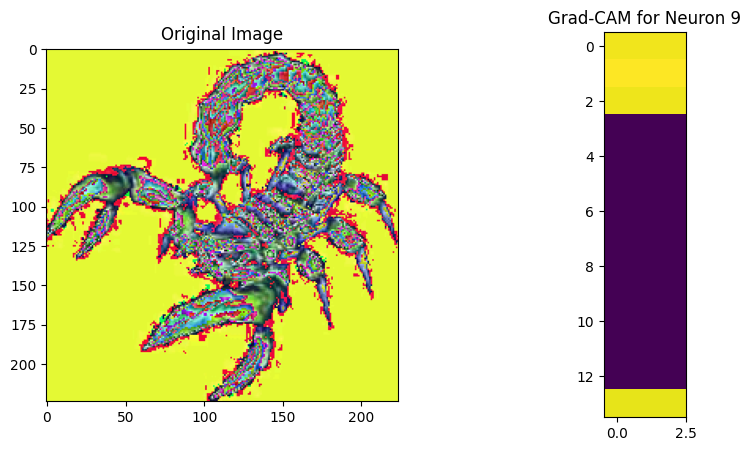

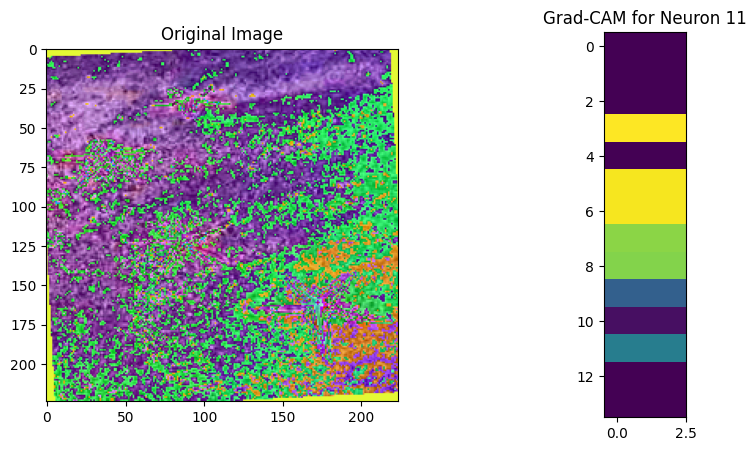

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
from torch.cuda.amp import autocast
from torchvision import models

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_gradcam_for_image(model, image, target_class):
    model.eval()
    activation = {}
    gradients = {}

    def hook_activation(module, input, output):
        activation['value'] = output

    def hook_gradients(module, grad_in, grad_out):
        gradients['value'] = grad_out[0]

    # Register hooks
    last_conv_layer = model.features[35]  # Adjust this index if necessary
    handle_activation = last_conv_layer.register_forward_hook(hook_activation)
    handle_gradients = last_conv_layer.register_backward_hook(hook_gradients)

    # Forward pass
    image = image.unsqueeze(0).to(device)
    with autocast():
        output = model(image)

    # Backward pass
    model.zero_grad()

    one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_()
    one_hot_output[0][target_class] = 1
    one_hot_output = one_hot_output.to(device) # Ensure one-hot tensor is on the same device as the model output

    output.backward(gradient=one_hot_output, retain_graph=True)

    # Retrieve activation and gradients
    activation_value = activation['value'].cpu().detach()
    gradients_value = gradients['value'].cpu().detach()

    # Compute Grad-CAM
    weights = torch.mean(gradients_value, dim=[0, 2, 3])
    cam = torch.zeros(activation_value.shape[2:], dtype=torch.float32)

    for i, w in enumerate(weights):
        cam += w * activation_value[0, i, :, :]

    cam = F.relu(cam)
    cam -= cam.min()
    cam /= cam.max()

    # Remove hooks
    handle_activation.remove()
    handle_gradients.remove()

    return cam.numpy(), activation_value.numpy()

def find_max_activated_neuron(activation_map):
    # Find the index of the neuron with maximum activation
    mean_activation = np.mean(activation_map, axis=(1, 2))
    max_activation_idx = np.argmax(mean_activation)
    return max_activation_idx

def visualize_patch_for_neuron(image, cam, neuron_idx):
    # Resize and normalize cam for visualization
    cam = np.interp(cam, (cam.min(), cam.max()), (0, 1))
    cam = np.uint8(255 * cam)

    # Generate heatmap
    heatmap = np.zeros_like(cam)
    heatmap[neuron_idx] = cam[neuron_idx]
    heatmap = np.sum(heatmap, axis=0)
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.stack([heatmap] * 3, axis=-1)

    # Overlay heatmap on the image
    image = TF.to_pil_image(image)
    image = np.array(image)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.title(f"Grad-CAM for Neuron {neuron_idx}")
    plt.show()

# Load the VGG19 model and prepare it
vgg19 = models.vgg19(pretrained=True)
vgg19.classifier[2] = torch.nn.Dropout(p=0.5)
vgg19.classifier[5] = torch.nn.Dropout(p=0.5)
vgg19.classifier[6] = torch.nn.Linear(4096, 5)

# Freeze convolutional layers
for name, param in vgg19.named_parameters():
    if "features" in name and "bn" not in name:
        param.requires_grad = True

vgg19.to(device)



# Find one image from each class
class_to_images = {class_idx: [] for class_idx in range(len(train_dataset.classes))}

for idx, (image, label) in enumerate(train_dataset):
    if len(class_to_images[label]) == 0:  # Pick the first image for each class
        class_to_images[label].append((image, label))

# Process one image from each class
for class_idx in range(len(train_dataset.classes)):
    image, target_class = class_to_images[class_idx][0]

    # Compute Grad-CAM
    try:
        cam, activation_map = compute_gradcam_for_image(vgg19, image, target_class)

        # Find the most activated neuron in the last convolutional layer
        neuron_idx = find_max_activated_neuron(activation_map)

        # Visualize the patch responsible for the maximum activation
        visualize_patch_for_neuron(image, cam, neuron_idx)
    except RuntimeError as e:
        print(f"Error processing class {class_idx}: {e}")
